In [1]:
import os
import json
import gzip
import pandas as pd
import numpy as np
from urllib.request import urlopen

In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 KB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.0 MB/s eta 0:00:00
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp39-cp39-linux_x86_64.whl size=81471 sha256=765308484c2a0029b13cfc7504337b245f8d1f671886379c8ccfb903c8ccbb5d
  Stored in directory: /root/.cache/pip/wheels/a6/28/ba/284e37010e5d3aeed5e45345b58ab8683f97bdce46c9e147f9
  Created wheel for pyDAWG: filename=pyDAWG-1.0.1-cp39-cp39-linux

## 1. Descarga, adecuación y filtrado del dataset

#### Antes de continuar, el preprocesado de la información se realizó en una workstation, por lo que se requierén hasta 32 GB, para procesar, sin embargo, se ha decidido utilizar un fragmento de los datos y con eso se trabajó

In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Cell_Phones_and_Accessories.json.gz --no-check-certificate

In [ ]:
### cargamos la metadata

data = []
with gzip.open('Cell_Phones_and_Accessories.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
# En caso contrario, entonces es windows, por lo que

# largo total de la lista, este numero es igual al numero total de productos
print(len(data))

# primer elemento de la lista
print(data[0])

### Apertura y conversión de todo el volumen de datos, cerca de 10 millones de reviews

In [ ]:
# Abrimos el json con los productos
data = []
with open('Cell_Phones_and_Accessories.json', 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))

In [ ]:
# convertimos la lista a pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))

In [ ]:
df.head(1000)

### Eliminación de registros nulos con base en reviewText y descripción de la información

In [ ]:
# Revisamos si hay valores nulos en la columna reviewText
df['reviewText'].isnull().sum()

# Removemos las filas con valores nulos en la columna reviewText
df = df.dropna(subset=['reviewText'])
print(len(df))

In [ ]:
# Describimos los datos
df.describe()

### Realizamos la vectorización usando countVectorizer y observamos el tamaño del vocabulario

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Instanciamos un objeto CountVectorizer 
vectorizer = CountVectorizer()

# Ajustamos el vectorizer sobte los datos de texto
vectorizer.fit(df['reviewText'])

# Calculamos el tamaño del vocabulario
vocab_size = len(vectorizer.vocabulary_)

print(f"Vocabulary size: {vocab_size}")


In [ ]:
# Revisamos si hay valores nulos o strings en la columna overall
df['overall'].isnull().sum()
df['overall'].dtype

# Convertimos la columna overall a int
df['overall'] = df['overall'].astype(int)


In [ ]:
# Distribución de reviews por número de estrellas
rating_counts = df['overall'].value_counts()

print("Distribución de los reviews por rating:")
print(rating_counts)

### Número de reviews positivas y negativas

Para determinar el número de reseñas positivas y negativas, se puede utilizar la columna 'overall' del conjunto de datos. En general, se considerarán positivas las reseñas con rating de 4 o 5 estrellas, mientras que se considerarán negativas las reseñas con rating de 1 o 2 estrellas. Las reseñas con rating de 3 estrellas se considerarán neutrales y se eliminarán del análisis.

In [ ]:
# Filtramos los reviews que no son 3 estrellas
filtered_data = df[df['overall'] != 3]

# Creamos la columna 'sentiment' con valor 1 para positivos y 0 para reviews negativos
filtered_data['sentiment'] = filtered_data['overall'].apply(lambda x: 1 if x > 3 else 0)

# Contamos los reviews positivos y negativos
sentiment_counts = filtered_data['sentiment'].value_counts()

print("Number of positive and negative reviews:")
print(sentiment_counts)

In [ ]:
# Para avanzar más rápido en el análisis, vamos a hacer un muestreo estratificado, tomamos el 25% de los reviews positivos y 25% de los negativos

# Creamos un nuevo dataframe con un porcentaje de positivos
positive_reviews = filtered_data[filtered_data['sentiment'] == 1].sample(frac=0.002, random_state=42)

# Creamos un dataframe con los negativos, un porcentaje mas o menos equilibrado
negative_reviews = filtered_data[filtered_data['sentiment'] == 0].sample(frac=0.006, random_state=42)

# Concatenamos
reduced_filtered_data = pd.concat([positive_reviews, negative_reviews])

# Contamos la cantidad de reviews positivos y negativos
sentiment_counts = reduced_filtered_data['sentiment'].value_counts()

print("Number of positive and negative reviews:")
print(sentiment_counts)

# Lo guardamos en un archivo csv
reduced_filtered_data.to_csv('amazon_reviews_reduced.csv', index=False)



Hasta este punto se considera la selección de una cierta cantidad de reviews para comenzar con el proceso 

## 2. Exploración 

In [57]:
# Cargamos el archivo csv reducido
reduced_filtered_data = pd.read_csv('amazon_reviews_reduced.csv')
# Contamos los reviews positivos y negativos
sentiment_counts = reduced_filtered_data['sentiment'].value_counts()

print("Numero de reviews positivas y negativas:")
print(sentiment_counts)

Numero de reviews positivas y negativas:
1    14315
0    12216
Name: sentiment, dtype: int64


In [11]:
reduced_filtered_data['reviewText'].isnull().sum()
#reduced_filtered_data['overall'].dtype
# Removemos las filas con valores nulos en la columna reviewText
reduced_filtered_data = reduced_filtered_data.dropna(subset=['reviewText'])

### N-grams mas frecuentes

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
# Instanciamos un vectorizer ngram_range=(1,2) para extraer unigrams y bigrams
vectorizer = CountVectorizer(ngram_range=(1,2))

# ajustamos
vectorizer.fit(reduced_filtered_data['reviewText'])

# Transformamos la información a sparse matrix 
X = vectorizer.transform(reduced_filtered_data['reviewText'])

# suma las ocurrencias de las caracteristicas
ngram_counts = X.sum(axis=0)

# Convertimos a numpy
ngram_counts_array = np.squeeze(np.asarray(ngram_counts))

# Obtenemos los indices y los ordenamos
sorted_indices = np.argsort(ngram_counts_array)[::-1]

# Obtenemos los 20 mejores unigrams y bigrams
top_ngrams = [(vectorizer.get_feature_names_out()[i], ngram_counts_array[i]) for i in sorted_indices[:20]]

print("Top 20 most frequent unigrams and bigrams:")
print(top_ngrams)

Top 20 most frequent unigrams and bigrams:
[('the', 54787), ('it', 36939), ('and', 27685), ('to', 24155), ('is', 15986), ('this', 15918), ('my', 15036), ('phone', 14225), ('for', 12807), ('of', 12560), ('case', 12470), ('not', 10850), ('on', 10264), ('in', 9686), ('that', 9153), ('was', 8817), ('but', 8459), ('with', 8315), ('have', 6664), ('you', 6545)]


### Nubes de palabras

Para visualizar las palabras más frecuentes en el conjunto de datos, vamos a utilizar una nube de palabras. Se puede utilizar la librería wordcloud para crear una nube de palabras.

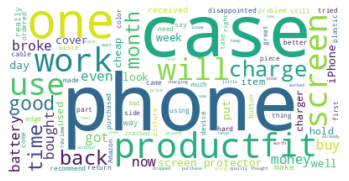

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Obtenemos los reviews negativos
negative_reviews = reduced_filtered_data[reduced_filtered_data['sentiment'] == 0]['reviewText'].str.cat(sep=' ')

# Creamos un wordcloud
wordcloud = WordCloud(max_words=100, background_color='white').generate(negative_reviews)

# mostramos usando matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

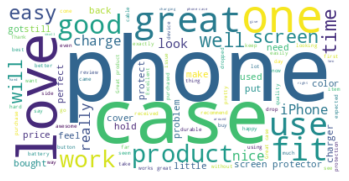

In [14]:
# Lo hacemos ahora con los reviews positivos
positive_reviews = reduced_filtered_data[reduced_filtered_data['sentiment'] == 1]['reviewText'].str.cat(sep=' ')

wordcloud = WordCloud(max_words=100, background_color='white').generate(positive_reviews)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec

Para visualizar los embeddings de palabras en un espacio de 2 dimensiones, se puede utilizar una técnica de reducción de dimensionalidad como PCA o t-SNE. En este caso, utilizamos t-SNE.

In [17]:
! python --version

Python 3.9.16


In [32]:
# Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec
import gensim

model = gensim.models.Word2Vec([review.split() for review in df['reviewText']], size=100, window=5, min_count=5, workers=4)
similar_words = model.wv.most_similar('camera', topn=10)
print(similar_words)

[('hole', 0.8516191244125366), ('cutout', 0.8443617820739746), ('speaker', 0.8348530530929565), ('cutouts', 0.7872101664543152), ('flash', 0.7815412878990173), ('lens', 0.7775309681892395), ('holes', 0.7744936943054199), ('area', 0.7662423253059387), ('sensor', 0.7630910277366638), ('speakers', 0.7614722847938538)]


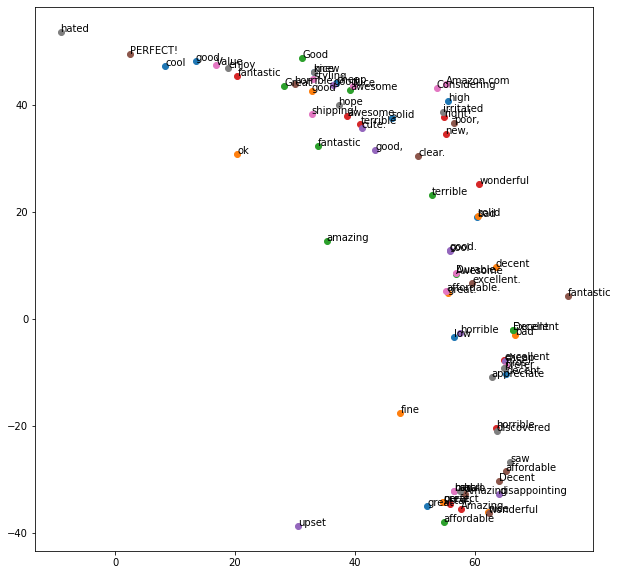

In [19]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# Train a Word2Vec model on the text data
sentences = [review.split() for review in reduced_filtered_data['reviewText']]
# Si no funciona así...
# model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
# Entonces funciona así...
model = Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
# Vamos a usar una serie de palabras para obtener las 10 mas similares de cada entrada
similar_words = {search_term: [item[0] for item in model.wv.most_similar([search_term], topn=10)]
                 for search_term in ['good', 'great', 'excellent', 'amazing', 'bad', 'terrible', 'awful', 'hate']}
# input_words = ['good', 'great', 'excellent', 'amazing', 'bad', 'terrible', 'awful', 'hate']
# similar_words = {word: [similar_word[0] for similar_word in model.wv.most_similar(word, topn=10)] for word in input_words}

# Convertimos el word embeddings a un 2D array usando t-SNE
tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne.fit_transform(model.wv.vectors)


# Graficamos en 2d
plt.figure(figsize=(10, 10))
for i, word in enumerate(similar_words.keys()):
    x = word_vectors_2d[i*10:(i+1)*10, 0]
    y = word_vectors_2d[i*10:(i+1)*10, 1]
    plt.scatter(x, y)
    for j, similar_word in enumerate(similar_words[word]):
        plt.annotate(similar_word, xy=(x[j], y[j]))
plt.show()


In [59]:
reduced_filtered_data.to_csv('reduced_filtered_data.csv', index=False)

Este código entrenará un modelo Word2Vec en el conjunto de datos y visualizará los embeddings de palabras en 2 dimensiones utilizando t-SNE. Se han seleccionado 5 palabras de entrada ('good', 'great', 'excellent', 'amazing', 'bad', 'terrible', 'awful', 'hate') y se han mostrado las 10 palabras más similares a cada una de ellas.

### Conclusiones de la exploración

En esta etapa se ha realizado un análisis exploratorio de los datos del conjunto de reseñas. 
Con el dataset completo: 
* Se ha calculado la cardinalidad del vocabulario.
* Se ha analizado la distribución de las reseñas por número de estrellas
* Se ha determinado el número de reseñas positivas y negativas
* Se han encontrado los N-grams más frecuentes
* Se ha creado una nube de palabras y 
* y se han visualizado algunos embeddings de palabras en 2 dimensiones.

A partir de estos análisis, se pueden obtener algunas conclusiones preliminares sobre el conjunto de datos. Por ejemplo, se ha encontrado que el tamaño del vocabulario es bastante grande, lo que sugiere que el conjunto de datos es bastante diverso en términos de vocabulario. También se ha encontrado que hay una mayor cantidad de reseñas positivas que negativas, lo que sugiere que el conjunto de datos puede estar desbalanceado.